## Self supervised large scale generalisation - Comparison

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
s3_training = "s3://aegovan-data/self-supervised/train.json"
s3_training = "s3://aegovan-data/self-supervised-fake/base/train.json"


s3_prefix_real = [
     "s3://aegovan-data/selfsupervised_chemprot/predictions_selfsupervised-real-1150-1150-208-bert--2022-10-24-03-31-14-781/2022102921/"
    ,"s3://aegovan-data/selfsupervised_chemprot/predictions_selfsupervised-real-1533-1533-278-bert--2022-11-01-15-36-34-436/2022110220/"
    ,"s3://aegovan-data/selfsupervised_chemprot/predictions_selfsupervised-real-2301-2301-417-bert--2022-10-31-00-44-01-898/2022103121/"
    ,"s3://aegovan-data/selfsupervised_chemprot/predictions_selfsupervised-real-3068-3068-556-bert--2022-11-03-03-37-11-451/2022110514/"
    ,"s3://aegovan-data/selfsupervised_chemprot/predictions_selfsupervised-real-3832-3832-695-bert--2022-11-05-02-16-26-120/2022110512/"
    ,"s3://aegovan-data/selfsupervised_chemprot/predictions_selfsupervised-real-5368-5368-973-bert--2022-10-24-03-34-43-158/2022102507/"
    ,"s3://aegovan-data/selfsupervised_chemprot/predictions_selfsupervised-real-7665-7665-1390-bert-2022-10-23-05-08-26-498/2022103021/"   
]

s3_prefix_fake = [
 "s3://aegovan-data/selfsupervised_chemprot/predictions_selfsupervised-fake-1531-767-286-bert-f-2022-11-01-15-32-44-405/2022110419/"
, "s3://aegovan-data/selfsupervised_chemprot/predictions_selfsupervised-fake-2293-767-445-bert-f-2022-10-31-00-45-11-186/2022103119/"
, "s3://aegovan-data/selfsupervised_chemprot/predictions_selfsupervised-fake-3048-767-573-bert-f-2022-11-03-03-37-09-320/2022110516/"   
, "s3://aegovan-data/selfsupervised_chemprot/predictions_selfsupervised-fake-3805-767-723-bert-f-2022-11-05-02-16-23-674/2022110513/"
, "s3://aegovan-data/selfsupervised_chemprot/predictions_selfsupervised-fake-8217-767-1593-bert--2022-10-16-20-14-51-295/2022103017/"
]

s3_prefixes = s3_prefix_real + s3_prefix_fake


In [3]:
label_order = ["False", "True"]
pos_labels = list( filter(lambda x: x , label_order))
label_order_key = lambda x:  label_order.index(x)

label_title_map = {}

In [4]:
local_temp = "../temp"
local_temp_pred_dir = os.path.join( local_temp, "pred_results")
local_temp_wk_dir = os.path.join( local_temp, "wk")

In [5]:
import shutil

def setup_dir(local_temp,local_temp_pred_dir, local_temp_wk_dir):
    if os.path.exists(local_temp):
        shutil.rmtree(local_temp)
    os.makedirs(local_temp_pred_dir)
    os.makedirs(local_temp_wk_dir)


In [6]:
import boto3
import glob
from multiprocessing.dummy import Pool as ThreadPool
import argparse
import datetime 
import os


def upload_file(localpath, s3path):
        """
Uploads a file to s3
        :param localpath: The local path
        :param s3path: The s3 path in format s3://mybucket/mydir/mysample.txt
        """

        bucket, key = get_bucketname_key(s3path)

        if key.endswith("/"):
            key = "{}{}".format(key, os.path.basename(localpath))
        
        s3 = boto3.client('s3')
        
        s3.upload_file(localpath, bucket, key)

def get_bucketname_key(uripath):
    assert uripath.startswith("s3://")

    path_without_scheme = uripath[5:]
    bucket_end_index = path_without_scheme.find("/")

    bucket_name = path_without_scheme
    key = "/"
    if bucket_end_index > -1:
        bucket_name = path_without_scheme[0:bucket_end_index]
        key = path_without_scheme[bucket_end_index + 1:]

    return bucket_name, key


def download_file(s3path, local_dir):
    bucket, key = get_bucketname_key(s3path)
    
    s3 = boto3.client('s3')
    
    local_file = os.path.join(local_dir, s3path.split("/")[-1])
    

    s3.download_file(bucket, key, local_file)
    
def download_object(s3path):
    bucket, key = get_bucketname_key(s3path)
    
    s3 = boto3.client('s3')    

    s3_response_object = s3.get_object(Bucket=bucket, Key=key)
    object_content = s3_response_object['Body'].read()
    
    return len(object_content)



def list_files(s3path_prefix):
    assert s3path_prefix.startswith("s3://")
    assert s3path_prefix.endswith("/")
    
    bucket, key = get_bucketname_key(s3path_prefix)
    
   
   
    s3 = boto3.resource('s3')
    
    bucket = s3.Bucket(name=bucket)

    return ( (o.bucket_name, o.key) for o in bucket.objects.filter(Prefix=key))





def upload_files(local_dir, s3_prefix, num_threads=20):    
    input_tuples = ( (f,  s3_prefix) for f in glob.glob("{}/*".format(local_dir)))
    
    with ThreadPool(num_threads) as pool:
        pool.starmap(uploadfile, input_tuples)
    


def download_files(s3_prefix, local_dir, num_threads=20):    
    input_tuples = ( ("s3://{}/{}".format(s3_bucket,s3_key),  local_dir) for s3_bucket, s3_key in list_files(s3_prefix))
    
    with ThreadPool(num_threads) as pool:
        results = pool.starmap(download_file, input_tuples)
        
        

def download_objects(s3_prefix, num_threads=20):    
    s3_files = ( "s3://{}/{}".format(s3_bucket,s3_key) for s3_bucket, s3_key in list_files(s3_prefix))
    
    with ThreadPool(num_threads) as pool:
        results = pool.map(download_object, s3_files)
        
    return sum(results)/1024
        

def get_directory_size(start_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            # skip if it is symbolic link
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)
    return total_size

def get_s3file_size(bucket, key):
    s3 = boto3.client('s3')
    response = s3.head_object(Bucket=bucket, Key=key)
    size = response['ContentLength']
    return size
    
def download_files_min_files(s3_prefix, local_dir, min_file_size=310, num_threads=20):    
    input_tuples = ( ("s3://{}/{}".format(s3_bucket,s3_key),  local_dir) for s3_bucket, s3_key in list_files(s3_prefix) if get_s3file_size(s3_bucket, s3_key) > min_file_size )
    
    with ThreadPool(num_threads) as pool:
        results = pool.starmap(download_file, input_tuples)
        


In [7]:
default_threshold =  0.99
threshold_config =  {l: { "confidence":default_threshold}  for l in label_order}


In [8]:
threshold_config

{'False': {'confidence': 0.99}, 'True': {'confidence': 0.99}}

In [9]:
def load_df_from_files(local_temp_pred_dir):
   
    list_df = []
    for f in os.listdir(local_temp_pred_dir):
        df = pd.read_json(os.path.join(local_temp_pred_dir, f), orient="records" )
        df["prediction"]=df["prediction"].astype(str)
        list_df.append(df)
    return pd.concat(list_df)


In [10]:
def get_summary_df(local_temp_pred_dir, use_std=False):
    list_df_high_quality = []
    list_df_low_quality = []
    list_df_summary = []
    for f in sorted(os.listdir(local_temp_pred_dir)):
        df = pd.read_json(os.path.join(local_temp_pred_dir, f), orient="records" )
        df["prediction"]=df["prediction"].astype(str)

        
        list_df_summary.append(df[["prediction", "confidence", "confidence_std", "abstract_id"]])

        # Filter below threshold items
        high_quality_frames_per_interaction = []
        low_quality_frames_per_interaction = []


        for k,t in threshold_config.items():
            conf_median = t["confidence"]
            conf_std_median = 1.0
            
            # HQ filter query
            high_qry = "prediction == '{}' and confidence >= {} and confidence_std <= {}" .format(k, conf_median, conf_std_median)
            if not use_std:
                high_qry = "prediction == '{}' and confidence >= {} " .format(k, conf_median)
            df_sub = df.query(high_qry)
           
            high_quality_frames_per_interaction.append(df_sub)


            # Low quality filter query
            conf_min = 0.8
            conf_std_min = 0.0
            low_qry = "prediction == '{}' and confidence < {} and confidence_std > {}" .format(k, conf_min, conf_std_min)
            if not use_std:
                low_qry = "prediction == '{}' and confidence < {} " .format(k, conf_min)
            df_low = df.query(low_qry)
            low_quality_frames_per_interaction.append(df_low)
           

        high_quality_df = pd.concat(high_quality_frames_per_interaction)
        low_quality_df = pd.concat(low_quality_frames_per_interaction)


        list_df_high_quality.append(high_quality_df)
        list_df_low_quality.append(low_quality_df)


    
    return pd.concat(list_df_high_quality), pd.concat(list_df_summary), pd.concat(list_df_low_quality)



In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



keywords1 = ["activation", "trigger", "interact", "inhibit", "regulat", "supress"]

keywords2 = ["gene", "protein", "chemical"]

def self_label(df):
   

    df["self_label"] = df["abstract"].apply(lambda x: any([ k.lower() in x.lower() for k in keywords1]) 
                                        and sum([  k.lower() in x.lower() for k in keywords2])>=2
                                     
                                       ).astype(str)
    
    
    return df

def plot_confusionmatrix(y_true,y_pred, normalize=None):
    cm = confusion_matrix(y_true,y_pred,labels=["False", "True"], normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels =  ["False", "True"])
    disp.plot(cmap="PuBu", xticks_rotation="vertical")

In [12]:
%%time 
from sklearn.metrics import precision_recall_fscore_support
import regex as re

def compute(prefixes): 
    results = []
    
    for s3_uri in prefixes:
        print(f"Running {s3_uri}")

        setup_dir(local_temp,local_temp_pred_dir, local_temp_wk_dir)
        download_files(s3_uri, local_temp_pred_dir)
        
        r = re.search(  "predictions_selfsupervised-(\w\w\w\w)-(\d+)-(\d+)-(\d+)", s3_uri)
        name= r.group(1)
        train_size= int(r.group(2))
        train_unique_size= int(r.group(3))
        train_pos_size= int(r.group(4))


            
        df_high_quality_threshold, df_summary, df_low_quality_threshold = get_summary_df (local_temp_pred_dir)

        gt = df_high_quality_threshold.pipe(self_label)["self_label"]

        p,r,f,s = precision_recall_fscore_support(gt, 
                         df_high_quality_threshold["prediction"], pos_label = "True", average="binary")
        
        total_predictions = len(df_high_quality_threshold)

        
        

        results.append({ "Name": name,  "Precision":p, "Recall":r, "F1":f,  "Threshold": "HighConfidence", "Support": s, 
                        "TrainSize":train_size, "TrainSizePositive": train_pos_size,
                        "TrainSizeUnique" : train_unique_size,
                        "PredictionsSize": total_predictions, 
                        "PredictionSampleSize": len(df_summary)})




        gt = df_low_quality_threshold.pipe(self_label)["self_label"]
        
        total_predictions = len(df_low_quality_threshold)


        p,r,f,s = precision_recall_fscore_support(gt, 
                         df_low_quality_threshold["prediction"], pos_label = "True",  average="binary")



        results.append({ "Name": name, "Precision":p, "Recall":r,  "F1":f, 
                        "Threshold": "LowConfidence", 
                        "Support": s,
                        "TrainSize":train_size, 
                        "TrainSizeUnique" : train_unique_size,
                        "TrainSizePositive": train_pos_size,
                        "PredictionsSize": total_predictions,
                       "PredictionSampleSize": len(df_summary)})
        
        
        
        # All
        
        df_all = pd.concat( [df_low_quality_threshold, df_high_quality_threshold])
        
        total_predictions = len(df_all)
        gt = df_all.pipe(self_label)["self_label"]


        p,r,f,s = precision_recall_fscore_support(gt, 
                         df_all["prediction"], pos_label = "True",  average="binary")



        results.append({ "Name": name, "Precision":p, "Recall":r,  "F1":f, 
                        "Threshold": "All", 
                        "Support": s,
                        "TrainSize":train_size, 
                        "TrainSizeUnique" : train_unique_size,
                        "TrainSizePositive": train_pos_size,
                        "PredictionsSize": total_predictions,
                       "PredictionSampleSize": len(df_summary)})
        
        
        
    df =  pd.DataFrame(results)
    
    df["SimilarityRatio" ] = df["TrainSizeUnique"].div(df["TrainSize"])
    df["PredictionsInThresholdRatio" ] = df["PredictionsSize"].div(df["PredictionSampleSize"])


    return df
    




df_compare = compute(s3_prefixes)
    


Running s3://aegovan-data/selfsupervised_chemprot/predictions_selfsupervised-real-1150-1150-208-bert--2022-10-24-03-31-14-781/2022102921/
Running s3://aegovan-data/selfsupervised_chemprot/predictions_selfsupervised-real-1533-1533-278-bert--2022-11-01-15-36-34-436/2022110220/
Running s3://aegovan-data/selfsupervised_chemprot/predictions_selfsupervised-real-2301-2301-417-bert--2022-10-31-00-44-01-898/2022103121/
Running s3://aegovan-data/selfsupervised_chemprot/predictions_selfsupervised-real-3068-3068-556-bert--2022-11-03-03-37-11-451/2022110514/
Running s3://aegovan-data/selfsupervised_chemprot/predictions_selfsupervised-real-3832-3832-695-bert--2022-11-05-02-16-26-120/2022110512/
Running s3://aegovan-data/selfsupervised_chemprot/predictions_selfsupervised-real-5368-5368-973-bert--2022-10-24-03-34-43-158/2022102507/
Running s3://aegovan-data/selfsupervised_chemprot/predictions_selfsupervised-real-7665-7665-1390-bert-2022-10-23-05-08-26-498/2022103021/
Running s3://aegovan-data/selfsupe

In [13]:
df_compare.query("Threshold == 'HighConfidence'")

,Name,Precision,Recall,F1,Threshold,Support,TrainSize,TrainSizePositive,TrainSizeUnique,PredictionsSize,PredictionSampleSize,SimilarityRatio,PredictionsInThresholdRatio
0,real,0.290048,0.708139,0.411535,HighConfidence,None,1150,208,1150,430378,500819,1.000000,0.859348
3,real,0.405013,0.923363,0.563054,HighConfidence,None,1533,278,1533,442125,500819,1.000000,0.882804
6,real,0.426609,0.927314,0.584377,HighConfidence,None,2301,417,2301,463945,500819,1.000000,0.926373
9,real,0.555164,0.865576,0.676460,HighConfidence,None,3068,556,3068,475447,500819,1.000000,0.949339
12,real,0.561916,0.861013,0.680030,HighConfidence,None,3832,695,3832,476898,500819,1.000000,0.952236
15,real,0.898102,0.876375,0.887105,HighConfidence,None,5368,973,5368,489457,500819,1.000000,0.977313
18,real,0.939574,0.935165,0.937364,HighConfidence,None,7665,1390,7665,494131,500819,1.000000,0.986646
21,fake,0.877462,0.587451,0.703750,HighConfidence,None,1531,286,767,461086,500819,0.500980,0.920664
24,fake,0.886271,0.813085,0.848102,HighConfidence,None,2293,445,767,449328,500819,0.334496,0.897186
27,fake,0.875756,0.783649,0.827146,HighConfidence,None,3048,573,767,453142,500819,0.251640,0.904802


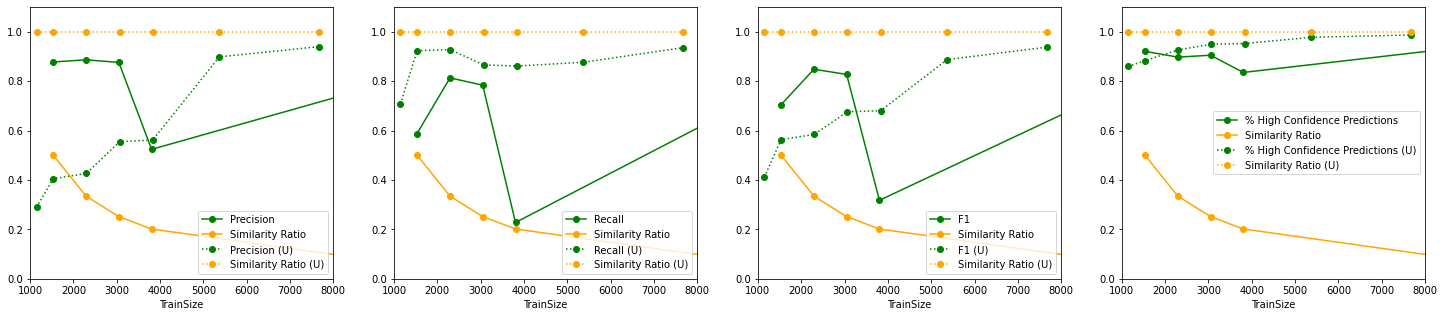

In [14]:
import warnings

def plot_comparison(df_compare):
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message=".*")

        fig, ax = plt.subplots(1,4, figsize=(25,5))
        my_colors= [ "green",  "orange"]
        for label, df in df_compare\
            [["Name","TrainSize","F1",  "Precision", "Recall", "SimilarityRatio", "PredictionsInThresholdRatio"]]\
            .groupby(["Name"  ]):
            linetype = "-"
            legend_suffix = ""
            if label == "real":
                linetype="dotted"
                legend_suffix = "(U)"
                
            column_renames={"Precision": "Precision " + legend_suffix, 
                            "SimilarityRatio" : "Similarity Ratio " + legend_suffix,
                            "Recall" : "Recall " + legend_suffix, 
                            "F1": "F1 " + legend_suffix, 
                            "PredictionsInThresholdRatio": "% High Confidence Predictions " + legend_suffix
                           }

            df[["TrainSize","Precision", "SimilarityRatio"]]\
                .rename(columns=column_renames)\
                .plot(x="TrainSize", linestyle =linetype, marker='o', ylim=(0,1.1), xlim=(1000, 8000), ax=ax[0], color=(my_colors))
            
            df[["TrainSize","Recall", "SimilarityRatio"]]\
                .rename(columns={"Recall": "Recall " + legend_suffix, 
                                 "SimilarityRatio" : "Similarity Ratio " + legend_suffix})\
                .plot(x="TrainSize", linestyle =linetype, marker='o', ylim=(0,1.1), xlim=(1000, 8000), ax=ax[1], color=(my_colors))
            
            df[["TrainSize","F1", "SimilarityRatio"]]\
                .rename(columns=column_renames)\
                .plot(x="TrainSize", linestyle =linetype, marker='o', ylim=(0,1.1), xlim=(1000, 8000), ax=ax[2], color=(my_colors))

            df[["TrainSize", "PredictionsInThresholdRatio", "SimilarityRatio"]]\
                .rename(columns=column_renames)\
                .plot(x="TrainSize", linestyle =linetype, marker='o', ylim=(0,1.1), xlim=(1000, 8000), ax=ax[3], color=(my_colors))

            plt.legend()

plot_comparison(df_compare.query("Threshold == 'HighConfidence'"))     

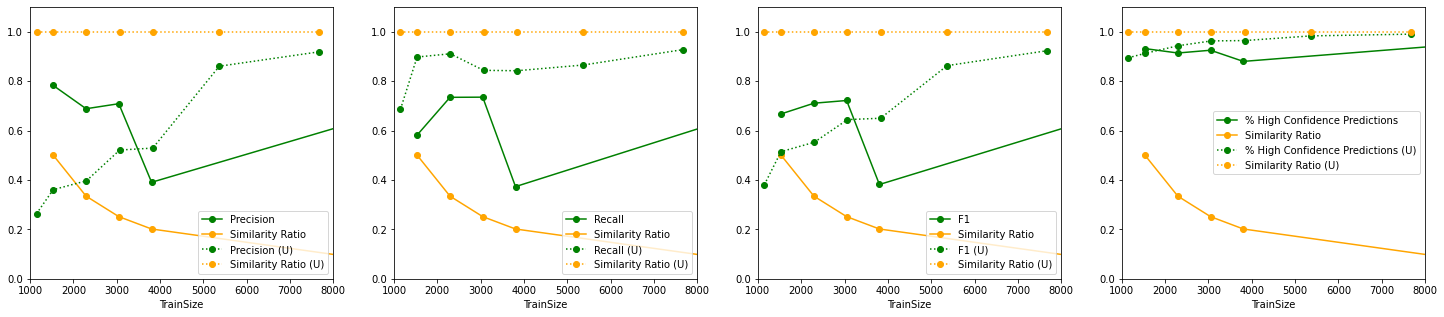

In [15]:
plot_comparison(df_compare.query("Threshold == 'All'"))  

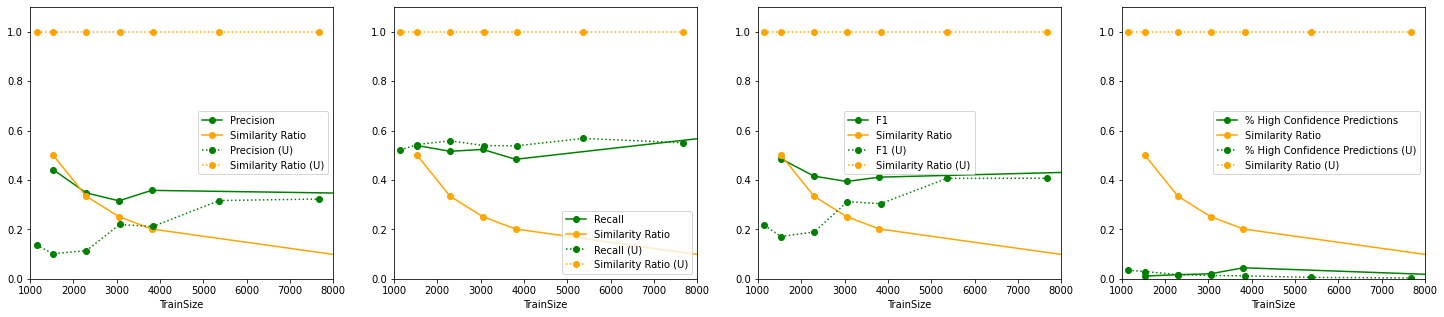

In [16]:
plot_comparison(df_compare.query("Threshold == 'LowConfidence'"))  

In [17]:
df_compare.query("Threshold == 'HighConfidence'")

,Name,Precision,Recall,F1,Threshold,Support,TrainSize,TrainSizePositive,TrainSizeUnique,PredictionsSize,PredictionSampleSize,SimilarityRatio,PredictionsInThresholdRatio
0,real,0.290048,0.708139,0.411535,HighConfidence,None,1150,208,1150,430378,500819,1.000000,0.859348
3,real,0.405013,0.923363,0.563054,HighConfidence,None,1533,278,1533,442125,500819,1.000000,0.882804
6,real,0.426609,0.927314,0.584377,HighConfidence,None,2301,417,2301,463945,500819,1.000000,0.926373
9,real,0.555164,0.865576,0.676460,HighConfidence,None,3068,556,3068,475447,500819,1.000000,0.949339
12,real,0.561916,0.861013,0.680030,HighConfidence,None,3832,695,3832,476898,500819,1.000000,0.952236
15,real,0.898102,0.876375,0.887105,HighConfidence,None,5368,973,5368,489457,500819,1.000000,0.977313
18,real,0.939574,0.935165,0.937364,HighConfidence,None,7665,1390,7665,494131,500819,1.000000,0.986646
21,fake,0.877462,0.587451,0.703750,HighConfidence,None,1531,286,767,461086,500819,0.500980,0.920664
24,fake,0.886271,0.813085,0.848102,HighConfidence,None,2293,445,767,449328,500819,0.334496,0.897186
27,fake,0.875756,0.783649,0.827146,HighConfidence,None,3048,573,767,453142,500819,0.251640,0.904802


In [18]:
import matplotlib.gridspec as gridspec

import numpy as np

def box_plot_prediction_confidence(df, df_high_quality, subplot_spec, title_prefix="", set_title=True):
    
    df = df[~df.RecordInTrainingData].copy()
    df_high_quality = df_high_quality[~df_high_quality.RecordInTrainingData].copy()
    
    
    interaction_types = label_order
    
    num_plots = len(interaction_types)
    gs = gridspec.GridSpecFromSubplotSpec(1, len(label_order), subplot_spec=subplot_spec)
    
    for i, interaction in enumerate(interaction_types):
        df_interaction = df.query(f"prediction == '{interaction}'")
        df_interaction_high_quality = df_high_quality.query(f"prediction == '{interaction}'")
        
        if len(df_interaction) == 0: continue
        
        ax = fig.add_subplot(gs[0, i])
    
    
        # Rename columns
        new_column_names = {"confidence":"c", 
                           "confidence_std" : "v"
                            }
        df_interaction = df_interaction.rename(columns = new_column_names)
        df_interaction_high_quality=df_interaction_high_quality.rename(columns = new_column_names)
        
        
        # Style and formatting..
        
        if set_title:
            ax.set_title("{}{}\nT={} (HQ={}%)".format( title_prefix,
                                               label_title_map.get(interaction, interaction).title(),
                                               len(df_interaction),
                                               round(100 * len(df_interaction_high_quality)/len(df_interaction),2)                
                                              )
                        )
        ax.set_ylim(0,1)
        
        ax.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)
        
        ax.spines['bottom'].set_color('grey')
        ax.spines['top'].set_color('grey') 
        ax.spines['right'].set_color('grey')
        ax.spines['left'].set_color('grey')
        
        
        # Plot violin plot        
        ax.violinplot(df_interaction[["c", "v" ]],  showmeans=True )
        if len(df_interaction_high_quality) > 0:
            ax.violinplot(df_interaction_high_quality[["c", "v" ]],  showmeans=True )
        
        
        x_labels = ['C', 'V']
        
        ax.xaxis.set_tick_params(direction='out')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xticks(np.arange(1, len(x_labels) + 1))
        ax.set_xticklabels(x_labels)
        ax.set_xlim(0.25, len(x_labels) + 0.75)
        
        
       



        


In [19]:
# fig = plt.figure(figsize=(25 , 7))
# gs = fig.add_gridspec(nrows=2)

# box_plot_prediction_confidence(df_summary, df_high_quality_threshold, gs[0])

# plt.savefig("largescaleprediction_distribution.pdf", bbox_inches="tight")